In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import json
import pandas as pd
import traceback

sys.path.append(".") # add results folder as a python path 
from viz import *
from analyze import *

In [2]:
# Global variables and statistics
dataset = 'data2'
dataset_name = 'LeNet5 on MNIST-1'
num_trials =100

lookup = load_lookup_data(dataset, '../lookup')
stats = get_difficulty_stats(lookup)
#print(lookup.keys())
n_samples = 20000
total_secs =  sum(lookup.duration)
total_hours = total_secs / 3600
mean_mins = total_secs / n_samples / 60
print("Execution time - total :  {:.2f}H, mean: {:.2f}M".format(total_hours, mean_mins))
for s in stats:
    print(s)
s = stats[3]
print("Selected target threshold: {}".format(s))
print("Global optimum: {:.4f}".format(np.max(lookup['best_acc'].values)))


Execution time - total :  2113.63H, mean: 6.34M
{'difficulty': 1.0, 'error': 0.008600000000000052, 'accuracy': 0.99139999999999995}
{'difficulty': 0.5, 'error': 0.0080000009999999788, 'accuracy': 0.99199999900000002}
{'difficulty': 0.1, 'error': 0.0069000009999999889, 'accuracy': 0.99309999900000001}
{'difficulty': 0.05, 'error': 0.0067000000000000393, 'accuracy': 0.99329999999999996}
{'difficulty': 0.01, 'error': 0.0062999999999999723, 'accuracy': 0.99370000000000003}
Selected target threshold: {'difficulty': 0.05, 'error': 0.0067000000000000393, 'accuracy': 0.99329999999999996}
Global optimum: 0.9939


In [3]:
# Read sequential optimization results
results = {}
opt_secs = 86400
postfix = ".HPO_emulator({})".format(num_trials)
s_path = "./{}/T{}S/".format(dataset, opt_secs)
basic_bo = ['GP-EI', 'GP-PI', 'GP-UCB', 
              'RF-EI', 'RF-PI', 'RF-UCB' ]
rand = ['Random']
sdivs = ['S-Div', 'S-Div (hybrid)']#['S-Div', 'S-Div (log)', 'S-Div (hybrid)']
ada = ['GP-Hedge']

results['Random'] = load_json(s_path + 'RANDOM-RANDOM' + postfix + '.json')

for opt in basic_bo:
    results[opt] = load_json(s_path + opt + postfix + '.json')

results['GP-Hedge'] = load_json(s_path + 'DIV-BO-HEDGE.hedge3' + postfix + '.json')


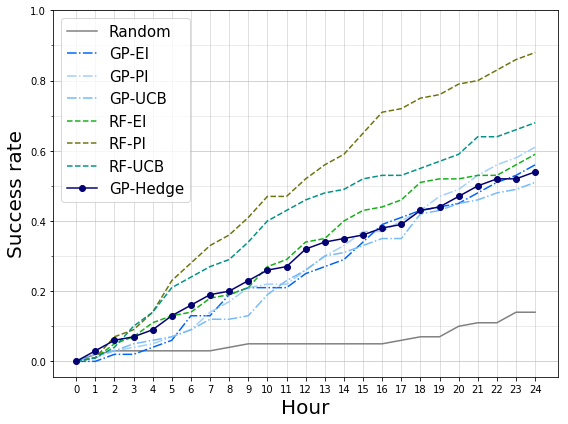

In [4]:
draw_success_rate_fig(results, s['accuracy'], 25, step_size=1,  
                                              width=8, height=6, save_name='fig-mnist2-s1', target_folder='./figs/',
                                              x_unit='Hour',  indi=rand+basic_bo,  ada=ada )

In [5]:
results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.pure' + postfix + '.json')
results['S-Div (log)'] = load_json(s_path + 'DIV-SEQ.log' + postfix + '.json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid' + postfix + '.json')
#results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM.hybrid' + postfix + '.json')

g_path = "./data2/G0.9933/"
threshold_etrs = {}
threshold_etrs['β=0.25'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizTetra4_HL(100)' + '.json')
threshold_etrs['β=0.2'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizPenta5_HL(100)' + '.json')
threshold_etrs['β=0.1'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizDeca10_HL(100)' + '.json')
threshold_etrs['β=0.05'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizIcosa20_HL(100)' + '.json')
threshold_etrs['β=0.0']= results['S-Div (hybrid)']



def restyle(name):
    marker = ''
    color = 'xkcd:red'
    if 'GP-Hedge' in name:
        color='xkcd:deep blue'
        marker = 'o'
    line_style = '--'
    if 'naive' in name:
        marker = '^'
    elif 'log' in name:
        marker = '*' 
    elif 'hybrid' in name:
        marker = 'o'
        line_style = '-'  
    return marker, color, line_style

draw_success_rate_fig(results, s['accuracy'], 25,   legend={'loc': 4},
                                              x_unit='Hour', step_size=1, style_format=restyle,
                                               div=['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)'], 
                                                 width=8, height=6,  save_name='fig-mnist2-s6', target_folder='./figs/',
                      num_runs=num_trials )


def restyle(name):
    marker = ''
    color = 'xkcd:orange'
    line_style = '--'
    if 'β=0.1' in name:
        marker = '*'
        line_style = '-'
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'       
    return marker, color, line_style

draw_success_rate_fig(threshold_etrs, s['accuracy'], 13, 
                                              x_unit='Hour', step_size=1, 
                                               div=threshold_etrs.keys(), legend={'loc': 4}, style_format=restyle,
                                                width=4, height=6,  save_name='fig-mnist2-s7', target_folder='./figs/',
                      num_runs=num_trials )

def restyle(name):
    marker = ''
    line_style = '--'
    color = 'red'    
    if 'ETR' in name:
        color ='xkcd:orange'
                
    if 'β=0.1' in name:
        marker = '*'  
        line_style = '-'
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'    
    
    if '(naive)' in name:
        marker = 'x'
    elif '(log)' in name:
        marker = '*'
    elif '(hybrid)' in name:
        marker = 'o' 
        line_style = '-'
    return marker, color, line_style

thresholds = []
for key in threshold_etrs.keys():
    if key != 'β=0.0':
        results['ETR ({})'.format(key)] = threshold_etrs[key]
        thresholds.append('ETR ({})'.format(key))

draw_success_rate_fig(results, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1, 
                                               div=['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)'] +thresholds, legend={'loc': 4}, style_format=restyle,
                                                width=8, height=6,  save_name='fig-mnist2-s8', target_folder='./figs/',
                      num_runs=num_trials )

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

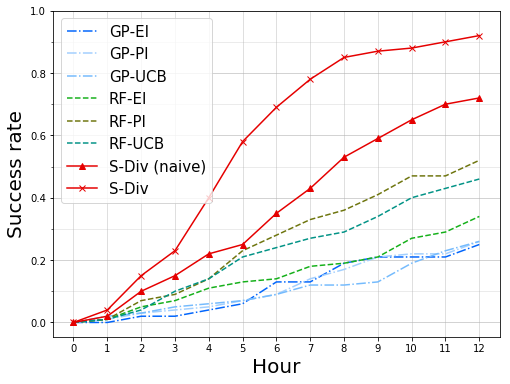

In [6]:
results[ 'S-Div']= threshold_etrs['β=0.1']
draw_success_rate_fig(results, s['accuracy'], 13, 
                                              x_unit='Hour', step_size=1,
                                               indi=basic_bo,  div=['S-Div (naive)',  'S-Div'], legend={'loc': 2},
                                                 width=8, height=6,  
                      #save_name='fig-mnist2-s2', target_folder='./figs/',
                      num_runs=num_trials )

results[ 'Sim']= load_json('./data2/T43200S/' + 'DIV-SEQ.hybrid-deca.HPO_runner.ETR-DecaTercet(10)' + '.json')
draw_success_rate_fig(results, s['accuracy'], 13, 
                                              x_unit='Hour', step_size=1,
                                               indi=basic_bo,  div=['Sim',  'S-Div'], legend={'loc': 2},
                                                 width=8, height=6,  
                      #save_name='fig-mnist2-s2', target_folder='./figs/',
                      num_runs=10 )

threshold_etrs = ['S-Div (hybrid)',  'S-Div + ETR(penta)', 'S-Div + ETR(deca)', ]
#results['S-Div + ETR(tetra)'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizTetra4_HL(100)' + '.json')
results['S-Div + ETR(penta)'] = load_json(g_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-PentaTercet(100)' + '.json')
results['S-Div + ETR(deca)'] = load_json(g_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-DecaTercet(100)' + '.json')
#results['S-Div + ETR(icosa)'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizIcosa20_HL(100)' + '.json')
draw_success_rate_fig(results, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1,
                                              div=threshold_etrs, legend={'loc': 4},
                                                width=8, height=6, # save_name='fig-mnist2-s2', target_folder='./figs/',
                      num_runs=num_trials )

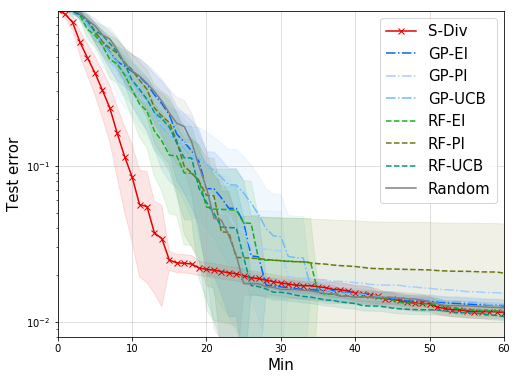

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [7]:
results['S-Div'] = load_json(s_path + 'DIV-SEQ.hybrid-deca-w12h.HPO_emulator.ETR-DecaTercet(100)' + '.json')
selected =['S-Div'] + basic_bo + rand
draw_best_error_curve(results, selected, 100, x_unit="Min",
                      ylim=(.008, .99), xlim=(0, 1*60), summary=True, x_steps=10,  
                      width=8, height=6, 
                      #save_name='fig-mnist2-s3', target_folder='./figs/',
#                      title="Sequential HPO of {}".format(dataset_name)
                     )

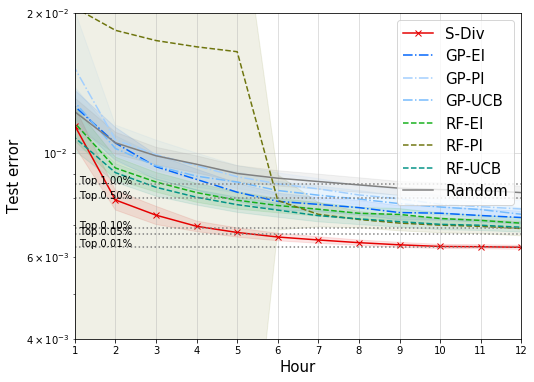

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [8]:
draw_best_error_curve(results, selected, 100, x_unit="Hour",
                      ylim=(.004, .02), xlim=(1, 12), summary=True, guidelines=stats, x_steps=1,  width=8, height=6, 
                     #save_name='fig-mnist2-s4', target_folder='./figs/',
                     )

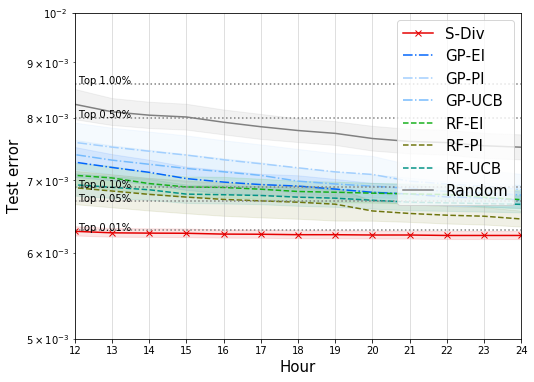

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
draw_best_error_curve(results, selected, 100, x_unit="Hour",
                      ylim=(.005, .01), xlim=(12, 24), summary=True, guidelines=stats, x_steps=1,  width=8, height=6, 
                     #save_name='fig-mnist2-s5', target_folder='./figs/',
                     )

In [10]:
# BOHB performance comparision 

etr_divs = [ 'S-Div', 'BOHB'] # 'BOHB (iter100)',  'S-Div (knock)',   'S-Div (interval)',
baselines = ['S-Div (naive)', 'Random']
etr_results = {}
etr_results.update(results)
num_runs = 100
etr_results['S-Div'] = results['S-Div']
etr_results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator(100).json')
etr_results['BOHB'] = load_json(s_path + 'BOHB.surrogate(100).json')


In [26]:
cfg = 'S-Div'
max_accs = []
for i in range(100):
    max_acc = max(etr_results[cfg][str(i)]['accuracy'])
    max_accs.append(max_acc)
print("{}\navg. {:.4f} ({:.4f})\nmax {}\n{}".format(cfg, np.mean(max_accs), np.std(max_accs), max(max_accs), 
                                                    [float("{:.4f}".format(acc)) for acc in max_accs]))

S-Div
avg. 0.9938 (0.0002)
max 0.9939
[0.9939, 0.9937, 0.9939, 0.9939, 0.9935, 0.9939, 0.9939, 0.9939, 0.9939, 0.9937, 0.9939, 0.9939, 0.9937, 0.9939, 0.9939, 0.9939, 0.9937, 0.9931, 0.9927, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9937, 0.9939, 0.9937, 0.9937, 0.9939, 0.9937, 0.9939, 0.9939, 0.9939, 0.9937, 0.9939, 0.9939, 0.9939, 0.9937, 0.9937, 0.9937, 0.9937, 0.9939, 0.9939, 0.9931, 0.9937, 0.9937, 0.9937, 0.9939, 0.9937, 0.9935, 0.9937, 0.9939, 0.9937, 0.9937, 0.9935, 0.9937, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9935, 0.9937, 0.9939, 0.9939, 0.9935, 0.9939, 0.9937, 0.9939, 0.9932, 0.9939, 0.9939, 0.9937, 0.9939, 0.9939, 0.9939, 0.9939, 0.993, 0.9939, 0.9937, 0.9939, 0.9939, 0.9937, 0.9937, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9937, 0.9935, 0.9935, 0.9939, 0.9939, 0.9939]


In [27]:
cfg = 'BOHB'
max_accs = []
for i in range(100):
    max_acc = max(etr_results[cfg][str(i)]['accuracy'])
    max_accs.append(max_acc)
print("{}\navg. {:.4f} ({:.4f})\nmax {}\n{}".format(cfg, np.mean(max_accs), np.std(max_accs), max(max_accs), 
                                                    [float("{:.4f}".format(acc)) for acc in max_accs]))

BOHB
avg. 0.9930 (0.0005)
max 0.9939
[0.9925, 0.9933, 0.9937, 0.9933, 0.9937, 0.9929, 0.9929, 0.9928, 0.9922, 0.9929, 0.9927, 0.9935, 0.9927, 0.9922, 0.9933, 0.993, 0.9924, 0.9937, 0.9929, 0.9933, 0.9928, 0.9937, 0.9937, 0.9932, 0.992, 0.9927, 0.9929, 0.9933, 0.9927, 0.9937, 0.9937, 0.9927, 0.9929, 0.9939, 0.9932, 0.9928, 0.9927, 0.993, 0.9931, 0.9933, 0.9929, 0.9925, 0.9935, 0.9937, 0.9933, 0.9937, 0.9935, 0.9935, 0.9915, 0.9923, 0.9933, 0.9912, 0.9931, 0.9933, 0.9932, 0.9929, 0.993, 0.9922, 0.993, 0.9932, 0.9924, 0.9927, 0.9927, 0.9937, 0.9937, 0.9939, 0.993, 0.9937, 0.9932, 0.9923, 0.9931, 0.9926, 0.9922, 0.9935, 0.9926, 0.9933, 0.9933, 0.9937, 0.9933, 0.9933, 0.9928, 0.9933, 0.9927, 0.9933, 0.9933, 0.9933, 0.9927, 0.9929, 0.9927, 0.9929, 0.9927, 0.9933, 0.9929, 0.9935, 0.9935, 0.9931, 0.9929, 0.992, 0.9932, 0.9925]


Target accuracy: 0.9933  (Top-0.05%)


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

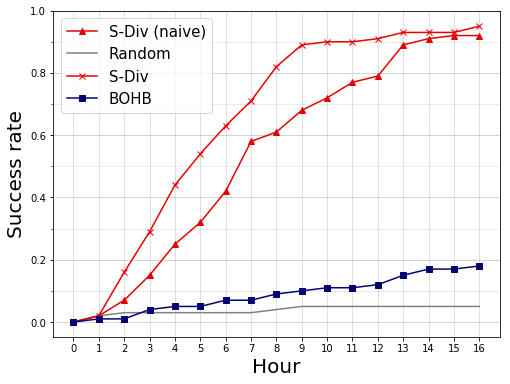

In [13]:
title = "Target accuracy: {}  (Top-{}%)".format(s['accuracy'], s['difficulty'])
print(title)
draw_success_rate_fig(etr_results, target_goal =s['accuracy'], x_max=17, x_unit='Hour', num_runs=num_runs,  #indi=basic_bo, 
                    div=baselines + etr_divs,  legend={'loc': 2},
                      #title=title, 
                      #save_name='fig-mnist2-s10', target_folder='./figs/',  
                    width=8, height=6  )

Target accuracy: 0.9914 (Top-1.0%)


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

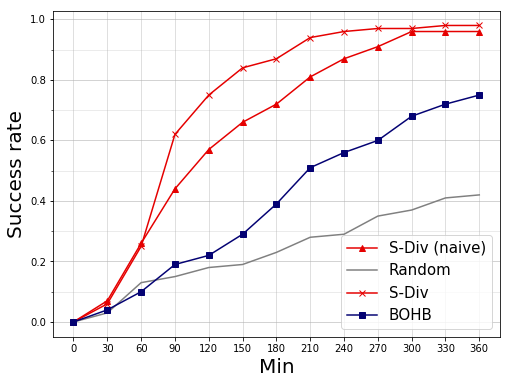

In [14]:
title = "Target accuracy: {} (Top-{}%)".format(stats[0]['accuracy'], stats[0]['difficulty'])
print(title)
draw_success_rate_fig(etr_results, target_goal =stats[0]['accuracy'], x_max=60*6+1, x_unit='Min' ,
                            div=baselines + etr_divs,  step_size=30,  
                      #title=title,
                      #save_name='fig-mnist2-s9', target_folder='./figs/',    
                      width=8, height=6 )

Target accuracy: 0.9920 (Top-0.5%)


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

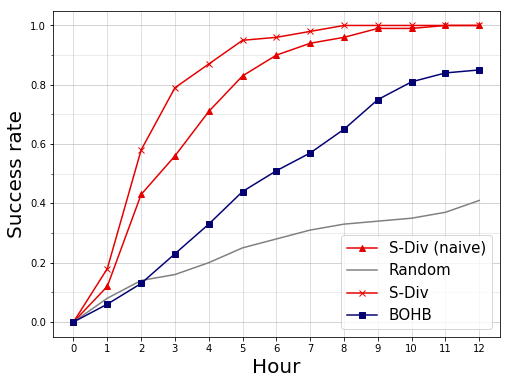

In [15]:
title = "Target accuracy: {:.4f} (Top-{}%)".format(stats[1]['accuracy'], stats[1]['difficulty'])
print(title)
draw_success_rate_fig(etr_results, target_goal =stats[1]['accuracy'], x_max=12+1, x_unit='Hour' ,
                            div=baselines + etr_divs, 
                       #                     save_name='fig-mnist2-s9', target_folder='./figs/',    
                      width=8, height=6 )


{'difficulty': 0.05, 'error': 0.0067000000000000393, 'accuracy': 0.99329999999999996}


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

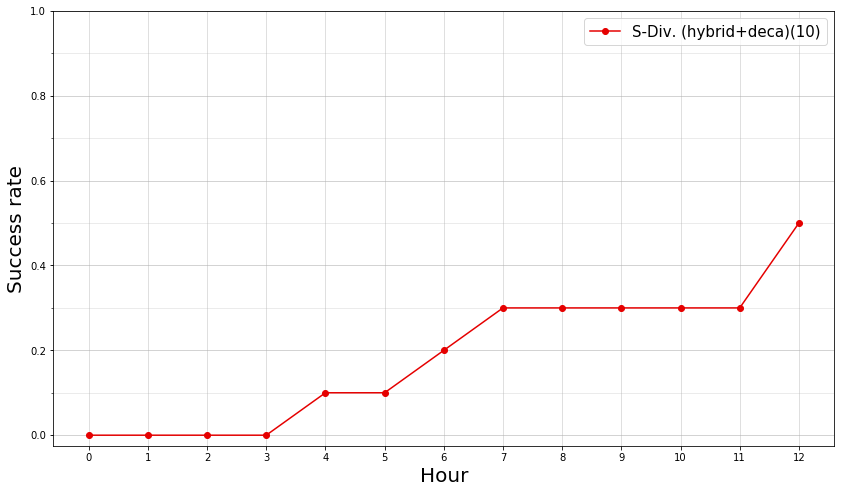

In [16]:
sa_path = "./{}/T{}S/".format(dataset, 43200)
bm_results = {}
bm_divs = ['S-Div. (hybrid+deca)(10)', ] # 'BOHB (3-13epoch)'
#bm_results['BOHB (3-13epoch)'] = load_json(sa_path + 'BOHB.3-13epoch.(5).json')

print(s)
bm_results['S-Div. (hybrid+deca)(10)'] = load_json(sa_path + 'DIV-SEQ.ti4a.hybrid-deca.(10).json')
draw_success_rate_fig(bm_results, target_goal =s['accuracy'], x_max=12 +1, x_unit='Hour' , num_runs=10, 
                            div=bm_divs, width=14, height=8 )

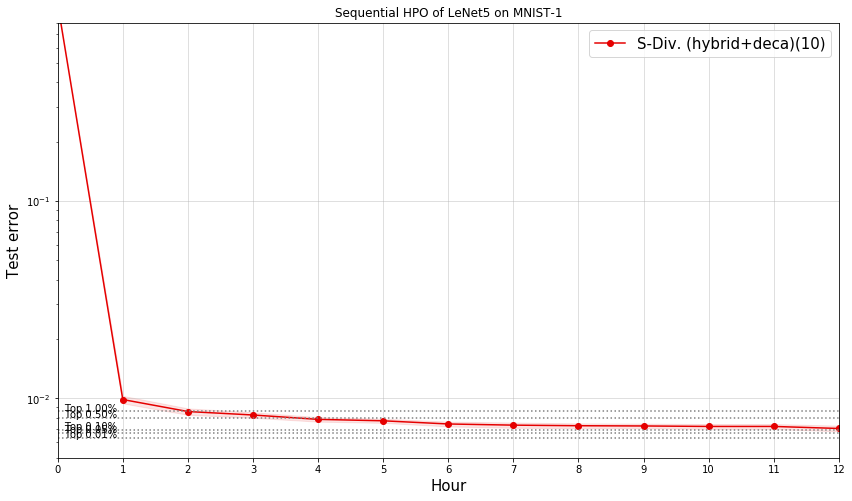

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [17]:
draw_best_error_curve(bm_results, bm_divs, 10, 
                      ylim=(.005, .8), xlim=(0, 12), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

draw_best_error_curve(bm_results, bm_divs, 10, 
                      ylim=(.005, .99), xlim=(0, 60*4), summary=True, guidelines=stats, x_steps=10, x_unit='Min', 
                      title="Sequential HPO of {}".format(dataset_name))

for i in range(10):
    draw_trials_curve(bm_results, 'S-Div. (hybrid+deca)(10)', i, xlim=(0, 12), width=15, height=8, loc=1, guidelines=stats)

for i in range(5):
    draw_trials_curve(bm_results, "BOHB (3-13epoch)", i, xlim=(0, 12), ylim=(.005, 1), width=15, height=8, loc=1, guidelines=stats)

etr_results['BOHB (30iter)'] = load_json(s_path + 'BOHB.iter30(2).json')
for i in range(2):
    draw_trials_curve(etr_results, "BOHB (30iter)", i, xlim=(0, 4), width=15, height=8, loc=1, guidelines=stats)

selected = ['S-Div (naive)', 'S-Div'] +['BOHB'] + ["Random"]
draw_best_error_curve(etr_results, selected, 2, 
                      ylim=(.005, .1), xlim=(0, 10), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.005, .99), xlim=(0, 24), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.005, .01), xlim=(0, 24), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', width=16, height=8, 
                      title="Sequential HPO of {}".format(dataset_name))

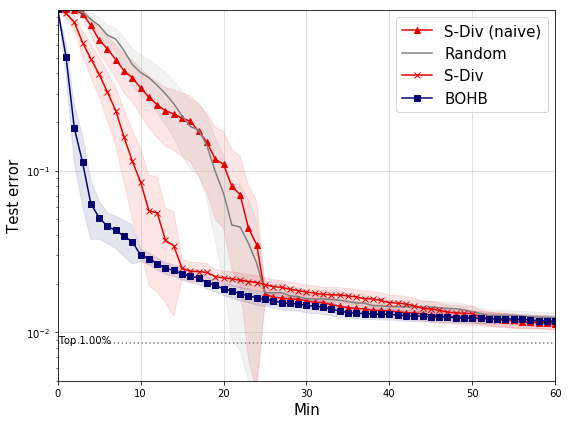

In [18]:
draw_best_error_curve(etr_results, baselines + etr_divs, num_runs, 
                      ylim=(.005, .99), xlim=(0, 1*60), summary=True, x_steps=10, x_unit='Min', guidelines=[stats[0]], 
                    save_name='fig-mnist2-s11', target_folder='./figs/',    
                      width=8, height=6 )

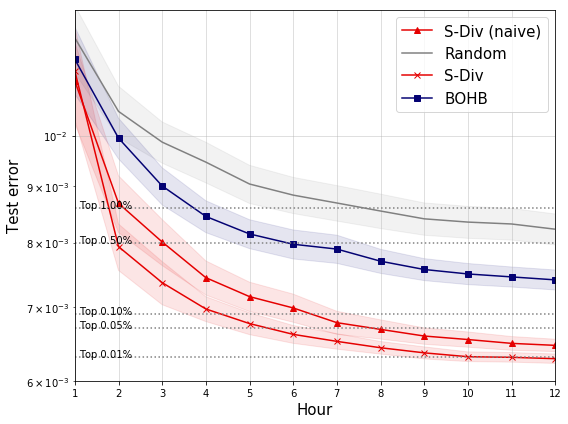

In [19]:
draw_best_error_curve(etr_results, baselines + etr_divs, num_runs, 
                      ylim=(.006, .013), xlim=(1, 12), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', #width=16, height=8, 
                       legend={"loc": 1},
                     save_name='fig-mnist2-s12', target_folder='./figs/',
                      width=8, height=6 )

In [20]:
# Read parallel optimization results ( 6 processors)
results_6 = {}
size = 6
max_x = 2 * 6 + 1
opt_secs = 14400
postfix = "({})".format(num_trials)
p_path = "./{}/T{}S/".format(dataset, opt_secs)
results_6['Synch. GP-EI-MCMC(10)'] = load_json(p_path + 'SYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(10)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(1)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI-no_mcmc' + postfix + '.json')
results_6['RF-EI'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6RF-EI' + postfix + '.json')

results_6['RF-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-PI' + postfix + '.json')
results_6['RF-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-UCB' + postfix + '.json')
results_6['GP-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-PI' + postfix + '.json')
results_6['GP-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-UCB' + postfix + '.json')

path = "./data2/G0.9933/"
results_6['P-Div (in-progress)'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.hybrid-deca(100)' + '.json')
results_6['P-Div (naive)'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (random)'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (next candidate)'] = load_json(path + 'ASYNC-BATCH.M6.FO-next_candidate.ETR-DecaTercet.hybrid-deca-next_cand(100).json')
results_6['P-Div'] = results_6['P-Div (in-progress)']

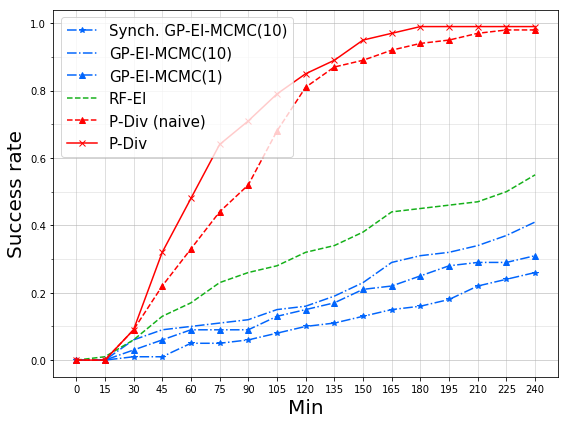

In [21]:
def restyle(name):
    marker = ''
    color ='black'
    line_style = '--'
    if 'GP-EI' in name:
        line_style = '-.'
        color = 'xkcd:bright blue'
    elif 'RF-EI' in name:
        color = 'xkcd:green'
    elif '-Div' in name:
        color = 'red'        
    if 'P-Div' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (naive)' == name:
        marker = '^'
    elif 'P-Div (in-progress)' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (random)' == name:
        marker = 'v' 
    elif 'P-Div (next candidate)' == name:
        marker = 'o'                
    elif 'MCMC(1)' in name:
        marker = '^' 
    elif 'Synch.' in name:
        marker = '*'
    return marker, color, line_style

parallels = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI',  'P-Div (naive)', 'P-Div']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(results_6, s['accuracy'], 4*60 + 1, x_unit="Min",
                                              step_size=15, style_format=restyle, 
                                               parallel=p_g, 
                                              width=8, height=6,  save_name='fig-mnist2-p1', target_folder='./figs/',
                                              num_runs=num_trials )

parallels = ['P-Div (in-progress)', 'P-Div (naive)', 'P-Div (random)', 'P-Div (next candidate)']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
draw_success_rate_fig(results_6, s['accuracy'], 4*60 + 1, x_unit="Min",
                                              step_size=15, style_format=restyle, 
                                               parallel=p_g, 
                                              width=8, height=6,  save_name='fig-mnist2-p2', target_folder='./figs/',
                                              num_runs=num_trials )

selected = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']

n_p = 6
num_trials = 100
flat_results_6 = {'Synch. GP-EI-MCMC(10)': results_6['Synch. GP-EI-MCMC(10)']}

for opt_name in [ 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']:
    sr_r = flatten_results(n_p, results_6, opt_name, num_trials)
    flat_results_6[opt_name] = sr_r

draw_best_error_curve(flat_results_6, selected, num_trials, x_unit='Min',
                      ylim=(.004, .5), xlim=(0, 60+1), summary=True, guidelines=stats, x_steps=5, style_format=restyle, legend={"loc": 1},
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

draw_best_error_curve(flat_results_6, selected, num_trials, x_unit='Hour',
                      ylim=(.005, .02), xlim=(1, 4), summary=True, guidelines=stats, x_steps=1, style_format=restyle, 
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

In [22]:
# For sequential HPO performance table generation
summary = []
checking_hours = [2, 4, 8, 12, 14, 16, 18, 20]
fail_summary = calc_catastrophic_failures(results, s['accuracy'], num_trials, 25)
s_comp_list = ['GP-EI', 'GP-PI', 'GP-UCB', 'RF-EI', 'RF-PI', 'RF-UCB', 'S-Div']
for key in s_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

,2h,4h,8h,12h,14h,16h,18h,20h,optimizer
0,2.0,4.0,19.0,25.0,29.0,39.0,43.0,45.0,GP-EI
1,3.0,5.0,17.0,26.0,33.0,37.0,43.0,49.0,GP-PI
2,3.0,6.0,12.0,26.0,31.0,35.0,42.0,45.0,GP-UCB
3,5.0,11.0,19.0,34.0,40.0,44.0,51.0,52.0,RF-EI
4,7.0,14.0,36.0,52.0,59.0,71.0,75.0,79.0,RF-PI
5,4.0,14.0,29.0,46.0,49.0,53.0,55.0,59.0,RF-UCB
6,16.0,44.0,82.0,91.0,93.0,95.0,95.0,95.0,S-Div


In [23]:
# For parallel HPO performance table generation
summary = []
checking_hours = [2] # 1, 2, 3, 4
p_comp_list = ['GP-EI-MCMC(10)', 'GP-PI', 'GP-UCB', 'RF-EI',  'RF-PI', 'RF-UCB','P-Div',]
fail_summary = calc_catastrophic_failures(results_6, s['accuracy'], num_trials, 5)
for key in p_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table1 = pd.DataFrame(summary)
table1

,2h,optimizer
0,16.0,GP-EI-MCMC(10)
1,8.0,GP-PI
2,16.0,GP-UCB
3,32.0,RF-EI
4,53.0,RF-PI
5,32.0,RF-UCB
6,85.0,P-Div


In [24]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in s_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

,1_optimizer,2_mean,3_sd
0,GP-EI,17.729427,7.434481
1,GP-PI,17.373250,7.350305
2,GP-UCB,18.053725,7.398136
3,RF-EI,16.485252,8.006888
4,RF-PI,12.197628,7.432840
5,RF-UCB,14.536739,8.495619
6,S-Div,5.942590,5.111899


In [25]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results_6)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in p_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

,1_optimizer,2_mean,3_sd
0,GP-EI-MCMC(10),3.304797,1.208668
1,GP-PI,3.669637,0.865830
2,GP-UCB,3.340131,1.146398
3,RF-EI,2.837221,1.405386
4,RF-PI,2.051505,1.262757
5,RF-UCB,2.836686,1.326793
6,P-Div,1.209666,0.702021
